# Лабораторная работа №2

# Решение задач линейного программирования с помощью симплекс метода

### Выполнил: Яковлев Артур, 853501

### Проверила: Костюкова О.И.

#### Вариант 28

Загрузка библиотек, необходимых для решения задачи

In [1]:
import numpy as np
import scipy.linalg as sla

Исходные данные для варианта 28 

In [17]:
dataset1 = (
    np.array([
        [1, 2, -1, 0, 3, 2, 3, 1, 5],
        [1, 0, 0, -1, -1, -3, 0, -6, 1],
        [0, 1, -4, 1, 3, 1, 0, 1, 0],
        [1, 2, -3, 1, -1, 2, 5, 0, 4],  # Матрица А
    ]),
    np.array([-1, -3, 1, -5, 2, -3, 1, -1, -1]),  # вектор с
    np.array([28.0, 59.0, -3.0, 3.0]),  # вектор b (в данной части не используется)
    [0, 3, 4, 7],  # индексы базисного плана
)
initial_plan = np.array([2, 0, 0, 7, 6, 0, 0, 8, 0])  # вектор базисного плана

Реализуем функции для расчета вектора ${\Delta_j}$

In [3]:
def approx(pot, opp_idx, A, c):
    results = [0.0] * A.shape[1]
    all_pos = True
    for i in opp_idx:
        results[i] = pot.dot(A[:, i]) - c[i]
        if np.abs(results[i]) < 1e-9:
            results[i] = 0.0
        elif results[i] < 0:
            all_pos = False
    return results if not all_pos else None

Далее реализуем сам алгоритм решения. В данной части мы проверяем, существует ли конечное решение задачи, и находим новый базисный план, если это возможно. Также в конце обновляем значение матрицы B по формуле $B' = MB$, где матрица M назодится аналогично заданию первой лабораторной.

In [10]:
def get_next_solution(dataset, B, x):
    A = dataset[0]
    c = dataset[1]
    b = dataset[2]
    idx = dataset[3]
    size = A.shape[1]
    opposite_idx = set(range(size))
    for i in idx:
        opposite_idx.remove(i)
    A_b = A[:, idx]
    c_b = c[idx]
    print("A_b: ")
    print(A_b)
    if B is None:
        B = sla.inv(A_b)
    
    print("B: ", B)
    print("Step 1")
    pot = np.dot(c_b, B)
    print("U: ", pot)
    approximation = approx(pot, opposite_idx, A, c)
    if approximation is None:
        print(f"{x} is already the most optimized plan")
        return x, None
    print("Approx: ", approximation)

    j = -1
    min_delta = 0
    for i in range(len(approximation)):
        if approximation[i] < min_delta:
            j = i
            min_delta = approximation[i]
    
    # print("J: ", j)
    # print("delta: ", min_delta)
    if j == -1:
        return None
    
    z = B.dot(A[:, j])
    print("Step 3")
    pos_idx = []
    for i in range(len(z)):
        if z[i] > 0.0:
            pos_idx.append(i)
        
    print("z: ", z)
    
    if len(pos_idx) == 0:
        return None, None
    
    min_value = None
    
    print("Step 4")
    for i in range(len(z)):
        value = x[idx[i]] / z[i]
        print("theta = ", value)
        if (min_value is None or value < min_value or np.abs(value - min_value) < 1e-9) and value > 1e-9:
            min_value = value
            x_idx = idx[i]
            z_idx = i
    
    print("final theta = ", min_value)
    print("index: ", z_idx)
    
    if min_value is None:
        print("Some error occured")
        return None, None
    
    new_x = np.zeros(x.shape)
    print("Step 5")
    print("Обновим план")
    print("Old x: ", x)
    for i in range(len(z)):
        new_x[idx[i]] = x[idx[i]] - min_value * z[i]
        if np.abs(new_x[idx[i]]) < 1e-9:
            new_x[idx[i]] = 0.0
    new_x[j] = min_value
    print("New x: ", new_x)
    idx.remove(x_idx)
    idx.append(j)
    idx.sort()
    # print("idx: ", idx)
    M = np.eye(len(z))
    d = np.zeros(len(z))
    for i in range(len(z)):
        d[i] = -z[i]
    print("Step 6")
    d[z_idx] = 1
    d /= z[z_idx]
    M[:, z_idx] = d
    print(f"M = {M}")
    B = M.dot(B)
    return new_x, B

Теперь с помощью реализации одной итерации, мы можем найти оптимальный план для нашей задачи

In [16]:
def solve(dataset, init_plan, max_iter=100):
    curr_plan = init_plan
    B = None
    for i in range(max_iter):
        print("\n=====================================\n")
        print(f"Iteration {i}")
        new_plan, B = get_next_solution(dataset, B, curr_plan)
        if curr_plan is None:
            print("No solution as function has no upper bound")
            break
        plans_equal = True
        for i in range(len(curr_plan)):
            if np.abs(new_plan[i] - curr_plan[i]) != 0:
                plans_equal = False
                break
        
        if plans_equal:
            print(curr_plan)
            break
        else:
            curr_plan = new_plan
    print(f"\n\nFinal plan: {curr_plan}")

In [18]:
# Before using this, activate part with dataset, otherwise some entries might have wrong values assigned to them
solve(dataset1, initial_plan)



Iteration 0
A_b: 
[[ 1  0  3  1]
 [ 1 -1 -1 -6]
 [ 0  1  3  1]
 [ 1  1 -1  0]]
B:  [[ 0.55   0.025 -0.4    0.425]
 [-0.45   0.025  0.6    0.425]
 [ 0.1    0.05   0.2   -0.15 ]
 [ 0.15  -0.175 -0.2    0.025]]
Step 1
U:  [ 1.75   0.125 -2.    -2.875]
Approx:  [0.0, -1.2499999999999991, 13.875, 0.0, 0.0, -1.6249999999999973, -10.124999999999998, 0.0, -1.6249999999999982]
Step 3
z:  [ 3.775  0.775 -0.45   0.575]
Step 4
theta =  0.5298013245033112
theta =  9.032258064516133
theta =  -13.333333333333332
theta =  13.913043478260867
final theta =  0.5298013245033112
index:  0
Step 5
Обновим план
Old x:  [2 0 0 7 6 0 0 8 0]
New x:  [0.         0.         0.         6.58940397 6.2384106  0.
 0.52980132 7.69536424 0.        ]
Step 6
M = [[ 0.26490066  0.          0.          0.        ]
 [-0.20529801  1.          0.          0.        ]
 [ 0.1192053   0.          1.          0.        ]
 [-0.15231788  0.          0.          1.        ]]


Iteration 1
A_b: 
[[ 0  3  3  1]
 [-1 -1  0 -6]
 [ 1  3

Рассмотрим решение задачи для другого варианта

In [20]:
dataset2 = (
    np.array([
        [1, 2, -1, 0, 3, 2, 3, 1, 5],
        [1, 0, 0, -1, -1, -3, 0, -6, 1],
        [0, 1, -4, 1, 3, 1, 0, 1, 0],
        [1, 2, -3, 1, -1, 2, 5, 0, 4],  # Матрица А
    ]),
    np.array([-1, -1, -1, -5, 1, -3, 1, -1, -1]),  # вектор с
    np.array([28.0, 59.0, -3.0, 3.0]),  # вектор b (в данной части не используется)
    [0, 1, 2, 7],  # индексы базисного плана
)
initial_plan2 = np.array([2, 4, 2, 0, 0, 0, 0, 4, 0])  # вектор базисного плана

In [21]:
# Update prev sell before launch
solve(dataset2, initial_plan2)



Iteration 0
A_b: 
[[ 1  2 -1  1]
 [ 1  0  0 -6]
 [ 0  1 -4  1]
 [ 1  2 -3  0]]
B:  [[-10.          -3.          -8.          14.        ]
 [  7.           2.           5.          -9.        ]
 [  1.33333333   0.33333333   0.66666667  -1.66666667]
 [ -1.66666667  -0.66666667  -1.33333333   2.33333333]]
Step 1
U:  [ 3.33333333  1.33333333  3.66666667 -5.66666667]
Approx:  [0.0, 0.0, 0.0, 1.6666666666666647, 24.33333333333335, -2.0000000000000018, -19.333333333333343, 0.0, -3.6666666666666643]
Step 3
z:  [ 40.         -24.          -4.33333333   6.66666667]
Step 4
theta =  0.04999999999999998
theta =  -0.16666666666666663
theta =  -0.4615384615384614
theta =  0.5999999999999998
final theta =  0.04999999999999998
index:  0
Step 5
Обновим план
Old x:  [2 4 2 0 0 0 0 4 0]
New x:  [0.         5.2        2.21666667 0.         0.         0.
 0.05       3.66666667 0.        ]
Step 6
M = [[ 0.025       0.          0.          0.        ]
 [ 0.6         1.          0.          0.        ]
 [ 0.




**Теперь с помощью данного алгоритма решим задачу оптимизации.**

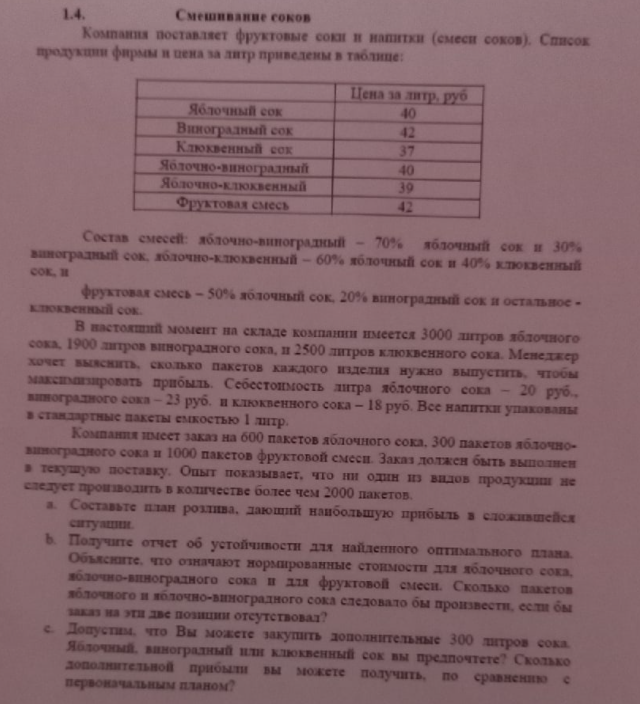

In [9]:
from IPython.display import Image
Image(filename='task.png') 

Из данного условия мы можем получить матрицу $A$, а также векторы $c$ и $b$

In [30]:
dataset3 = (
    np.array([
        [0.7, 0.6, 0.5, 1., 0., 0.],
        [0.3, 0.4, 0.2, 0., 1., 0.],
        [0.,  0.,  0.3, 0., 0., 1.],  # Матрица А
    ]),
    np.array([19.1, 19.8, 22., 20., 19., 19.]),  # вектор с
    np.array([3000, 1900, 2500]),  # вектор b (в данной части не используется)
    [3, 4, 5],  # индексы базисного плана
)

Остается найти вектор базисного плана

Для этого выберем матрицу $A_б$ такую, что ее определитель не равен нулю. Самым очевидным решением является 4-6 столбцы матрицы, образующие единичную матрицу.

Далее воспользуемся формулой $x_б = A_б^{-1} b$

In [26]:
dataset3[0][:, 3:].dot(dataset3[2])

array([3000., 1900., 2500.])

Получим план:

In [31]:
initial_plan3 = np.array([0., 0., 0., 3000., 1900., 2500.])

Теперь воспользуемся нашим алгоритмом для решения задачи

In [32]:
solve(dataset3, initial_plan3)



Iteration 0
A_b: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
B:  [[ 1. -0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
Step 1
U:  [20. 19. 19.]
Approx:  [0.5999999999999979, -0.1999999999999993, -2.5, 0.0, 0.0, 0.0]
Step 3
z:  [0.5 0.2 0.3]
Step 4
theta =  6000.0
theta =  9500.0
theta =  8333.333333333334
final theta =  6000.0
index:  0
Step 5
Обновим план
Old x:  [   0.    0.    0. 3000. 1900. 2500.]
New x:  [   0.    0. 6000.    0.  700.  700.]
Step 6
M = [[ 2.   0.   0. ]
 [-0.4  1.   0. ]
 [-0.6  0.   1. ]]


Iteration 1
A_b: 
[[0.5 0.  0. ]
 [0.2 1.  0. ]
 [0.3 0.  1. ]]
B:  [[ 2.   0.   0. ]
 [-0.4  1.   0. ]
 [-0.6  0.   1. ]]
Step 1
U:  [25. 19. 19.]
[   0.    0. 6000.    0.  700.  700.] is already the most optimized plan
[   0.    0. 6000.    0.  700.  700.]


Final plan: [   0.    0. 6000.    0.  700.  700.]


Найдем $cx$

In [34]:
dataset3[1] @ np.array([0., 0., 6000., 0., 700., 700.])

158600.0